# Cryptocurrencies project

## Loading libraries

In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession

In [5]:
from os.path import abspath

warehouse_location = abspath('spark-warehouse')

## Spark session

In [6]:
spark = (
    SparkSession.builder
    .appName("Crypto-analytics")
    .config("spark.sql.warehouse.dir", warehouse_location) \
    .enableHiveSupport() \
    .getOrCreate()
)

23/01/08 21:12:10 WARN util.Utils: Your hostname, node1 resolves to a loopback address: 127.0.0.1; using 10.0.2.15 instead (on interface enp0s3)
23/01/08 21:12:10 WARN util.Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/01/08 21:12:11 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


## Test prints

In [7]:
spark.sql("select * from crypto_rates_2 limit 50;").show()

23/01/08 21:12:23 WARN session.SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


+-------------------+------------------+--------------------+----+-----+---+
|cryptocurrency_name|       rate_in_usd|      timestamp_date|year|month|day|
+-------------------+------------------+--------------------+----+-----+---+
|        persistence|0.5196202981311041|2022-12-29 14:21:...|2022|   12| 29|
|              waves|1.3541603305700813|2022-12-29 13:42:...|2022|   12| 29|
|        persistence|0.5197367845106337|2022-12-29 11:42:...|2022|   12| 29|
|              waves|1.3492412703140595|2022-12-29 12:18:...|2022|   12| 29|
|              waves|1.3554867041822647|2022-12-29 13:50:...|2022|   12| 29|
|              waves|1.3476784370963413|2022-12-29 11:42:...|2022|   12| 29|
|        persistence|0.5195556585990367|2022-12-29 12:07:...|2022|   12| 29|
|        persistence| 0.519715688174103|2022-12-29 13:42:...|2022|   12| 29|
|        persistence|0.5197367790193458|2022-12-29 11:42:...|2022|   12| 29|
|              waves| 1.350400513178061|2022-12-29 12:07:...|2022|   12| 29|

In [8]:
spark.sql("select * from crypto_rates_2 limit 50;").printSchema()

root
 |-- cryptocurrency_name: string (nullable = true)
 |-- rate_in_usd: double (nullable = true)
 |-- timestamp_date: timestamp (nullable = true)
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- day: integer (nullable = true)



## Crypto rates visualisations

### Observed rates

In [29]:
currencies = spark.sql(
    "select distinct cryptocurrency_name from crypto_rates_2"
).toPandas()['cryptocurrency_name'].tolist()

In [30]:
currencies

['multi-collateral-dai',
 'dash',
 'persistence',
 'zcash',
 'litecoin',
 'eos',
 'bitcoin-cash',
 'dogecoin',
 'sentinel',
 'crypto-com-coin',
 'binance-coin',
 'waves',
 'tether',
 'bitcoin',
 'qtum',
 'thorchain',
 'ethereum']

### Mean values of cryptocurencies rates in USD

In [11]:
out1_raw = spark.sql(
    "select cryptocurrency_name, mean(rate_in_usd) as mean_val from crypto_rates_2 group by cryptocurrency_name"
)

In [12]:
out1_raw.write.format("parquet").mode("overwrite").save(
    "/user/vagrant/projekt/analytical_part/mean_rates.parquet")

In [13]:
out1 = out1_raw.toPandas()

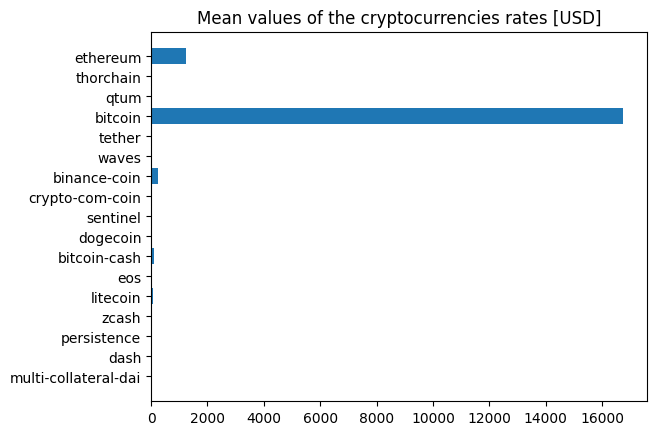

In [14]:
plt.barh(out1['cryptocurrency_name'], out1['mean_val'])
plt.title('Mean values of the cryptocurrencies rates [USD]')
plt.show()

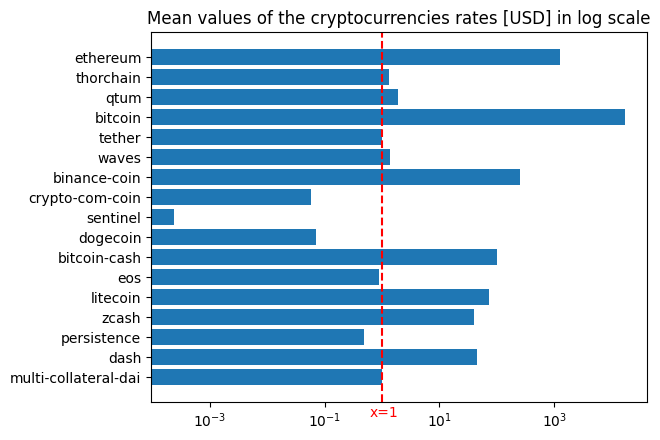

In [96]:
plt.barh(out1['cryptocurrency_name'], out1['mean_val'])
plt.title('Mean values of the cryptocurrencies rates [USD] in log scale')
plt.xscale('log')
plt.axvline(x = 1, color = 'red', linestyle = 'dashed')
plt.text(0.6, -2, 'x=1', color='red')
plt.show()

### Variance of cryptocurencies rates in USD

In [16]:
out2_raw = spark.sql(
    "select cryptocurrency_name, variance(rate_in_usd) as var_val from crypto_rates_2 group by cryptocurrency_name"
)

In [17]:
out2 = out2_raw.toPandas()

In [18]:
out2_raw.write.format("parquet").mode("overwrite").save(
    "/user/vagrant/projekt/analytical_part/variance_rates.parquet")

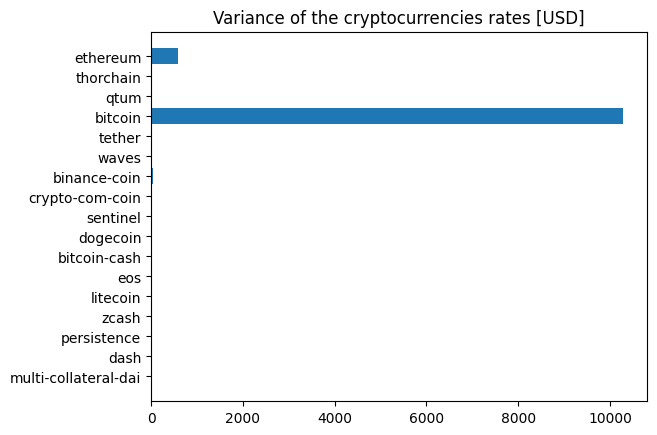

In [19]:
plt.barh(out2['cryptocurrency_name'], out2['var_val'])
plt.title('Variance of the cryptocurrencies rates [USD]')
plt.show()

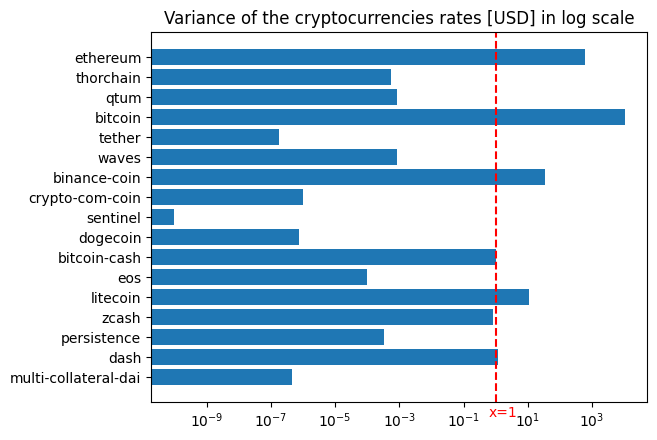

In [97]:
plt.barh(out2['cryptocurrency_name'], out2['var_val'])
plt.title('Variance of the cryptocurrencies rates [USD] in log scale')
plt.xscale('log')
plt.axvline(x = 1, color = 'red', linestyle = 'dashed')
plt.text(0.6, -2, 'x=1', color='red')
plt.show()

### Lineplot of cryptocurrencies rate changes aggregated to hour means

In [40]:
def get_lineplot_data_averaged_each_hour(crypto):
    return spark.sql(
        """
        select cryptocurrency_name, mean(rate_in_usd) as mean_val, date from
            (select cryptocurrency_name, date_trunc('HOUR', timestamp_date) as date, rate_in_usd from crypto_rates_2)
        where cryptocurrency_name = '""" + crypto + """'
        group by date, cryptocurrency_name
        order by date
        """
    )

In [41]:
currencies = currencies[1:]

In [42]:
out3_raw = [get_lineplot_data_averaged_each_hour(cr) for cr in currencies]

In [44]:
for j in range(len(out3_raw)):
    out3_raw[j].write.format("parquet").mode("overwrite").save(
        "/user/vagrant/projekt/analytical_part/aggregated_" + currencies[j] + ".parquet")

In [47]:
out3 = [out3_raw[0].toPandas()]

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


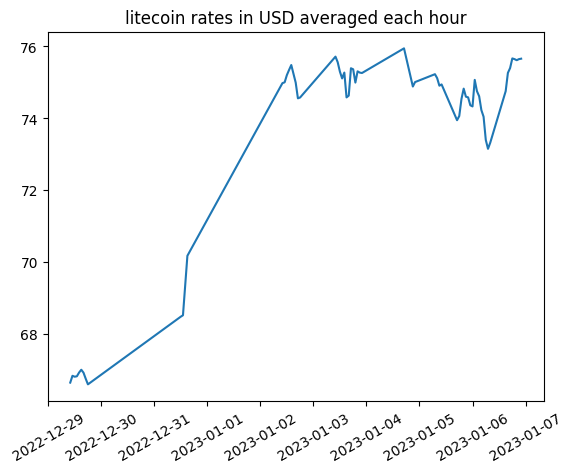

In [49]:
i = 0
plt.plot(out3[i]['date'], out3[i]['mean_val'])
plt.title(f'{currencies[i]} rates in USD averaged each hour')
plt.xticks(rotation=30)
plt.show()

### Heatmap of year changes between lowest and highest value

In [50]:
out4 = spark.sql(
    """
    select cryptocurrency_name, ((max(rate_in_usd) / min(rate_in_usd)) - 1) as change, year
    from 
        (select cryptocurrency_name, year(timestamp_date) as year, rate_in_usd from crypto_rates_2)
    group by cryptocurrency_name, year
    """
)

In [51]:
out4_pivot_raw = out4.groupBy("cryptocurrency_name").pivot("year").sum("change")

In [52]:
out4_pivot_raw.write.format("parquet").mode("overwrite").save(
    "/user/vagrant/projekt/analytical_part/rate_differences.parquet")

In [53]:
out4_pivot_pandas = out4_pivot_raw.toPandas()

In [54]:
out4_pivot_pandas = out4_pivot_pandas.set_index('cryptocurrency_name')
out4_pivot_pandas

,2022,2023
cryptocurrency_name,,
multi-collateral-dai,0.001823,0.007651
dash,0.030835,0.077582
persistence,0.054942,0.137235
zcash,0.008917,0.085533
litecoin,0.056670,0.044006
eos,0.011086,0.043368
bitcoin-cash,0.025973,0.041849
dogecoin,0.017938,0.060112
sentinel,0.064377,0.157549


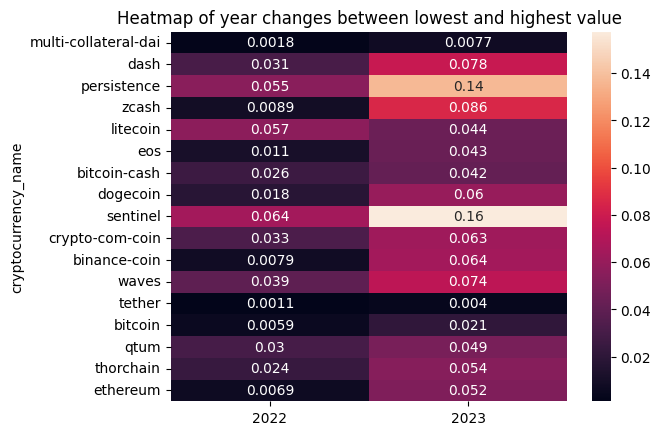

In [55]:
sns.heatmap(out4_pivot_pandas, annot=True)
plt.title("Heatmap of year changes between lowest and highest value")
plt.show()

## Crypto news visualisations

In [56]:
import happybase
import pandas as pd

In [57]:
def filter_hbase(filter_func, columns):
    connection = happybase.Connection('0.0.0.0')
    table = connection.table("crypto_news")
    
    columns = [str(c, 'UTF-8') for c in columns]
    
    x = {}
    for c in columns:
        x[c] = []
    
    output_df = pd.DataFrame(x)
    
    for key, data in table.scan():
        d = {}
        for column, value in data.items():
            if filter_func(key, column, value):
                d[str(column, 'UTF-8')] = [str(value, 'UTF-8')]
        dataframe = pd.DataFrame.from_dict(d, orient='columns')
        dataframe = dataframe[columns]
        output_df = pd.concat([output_df, dataframe])
            
    return output_df

In [58]:
all_columns = [b'count:count_BCH',
 b'count:count_BNB',
 b'count:count_BTC',
 b'count:count_CRO',
 b'count:count_DAI',
 b'count:count_DASH',
 b'count:count_DOGE',
 b'count:count_DVPN',
 b'count:count_EOS',
 b'count:count_ETH',
 b'count:count_LTC',
 b'count:count_QTUM',
 b'count:count_RUNE',
 b'count:count_USDT',
 b'count:count_WAVES',
 b'count:count_XPRT',
 b'count:count_ZEC',
 b'data:date',
 b'data:sentiment',
 b'data:source_id',
 b'data:title',               
 b'lang:country',                                                     
 b'lang:language'
]

In [59]:
def d(key, column, value):
    return True
    
o = filter_hbase(d, all_columns)

In [60]:
o['data:date'].tolist()

['2023-01-08 04:00:43',
 '2023-01-08 03:30:05',
 '2023-01-07 05:30:40',
 '2023-01-07 07:30:43',
 '2023-01-08 08:45:00',
 '2023-01-08 10:37:35',
 '2023-01-08 08:30:00',
 '2023-01-08 08:15:16',
 '2023-01-07 07:58:56',
 '2023-01-07 08:23:23',
 '2023-01-07 11:05:38',
 '2023-01-07 08:35:00',
 '2023-01-08 09:07:37',
 '2023-01-08 07:53:00',
 '2023-01-08 02:05:00',
 '2023-01-07 09:17:18']

### Histogram of languages

In [61]:
hb1 = filter_hbase(lambda x, y, z: True, [b'lang:language'])

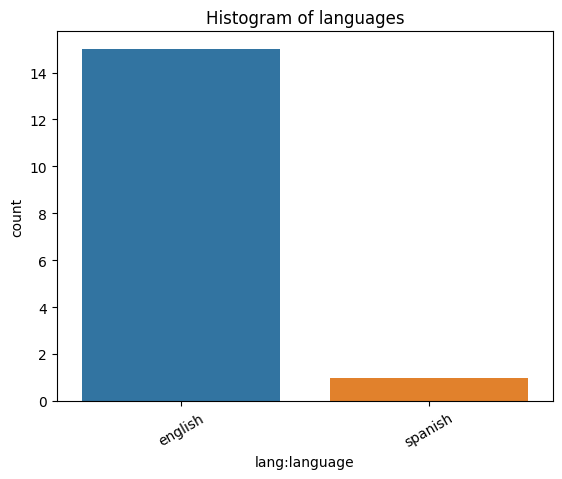

In [62]:
sns.countplot(x=hb1['lang:language'])
plt.title("Histogram of languages")
plt.xticks(rotation=30)
plt.show()

### Histogram of sentiment

In [63]:
hb2 = filter_hbase(lambda x, y, z: True, [b'data:sentiment'])

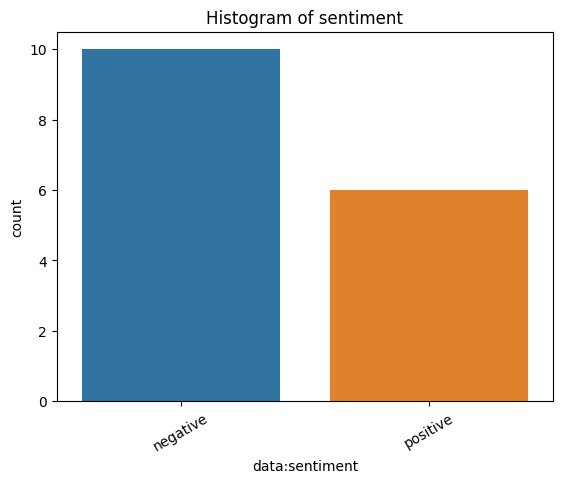

In [64]:
sns.countplot(x=hb2['data:sentiment'])
plt.title("Histogram of sentiment")
plt.xticks(rotation=30)
plt.show()

### Heatmap of currency mentions and sentiment

In [65]:
hb2 = filter_hbase(lambda x, y, z: True, all_columns[0:17] + [all_columns[18]])
cols = [str(c, 'UTF-8') for c in all_columns[0:17]]
hb2[cols] = hb2[cols].astype('int64')
hb2 = hb2.groupby('data:sentiment').sum()
hb2 = hb2.T
hb2 = hb2.reset_index()
hb2['index'] = hb2['index'].apply(lambda x: x.replace('count:count_', ''))
hb2 = hb2.set_index('index')

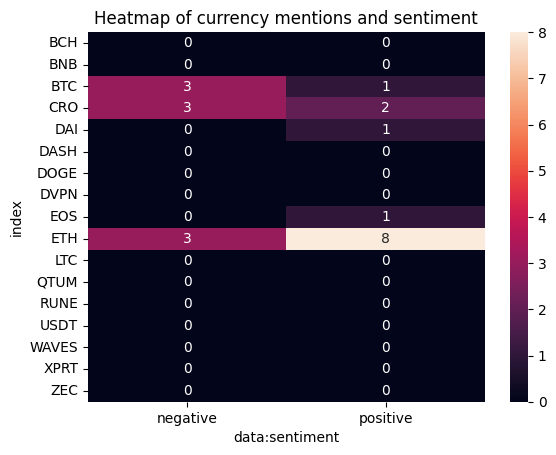

In [66]:
sns.heatmap(hb2, annot=True)
plt.title("Heatmap of currency mentions and sentiment")
plt.show()

## Visualisations of combination of crypto news and crypto rates

Mean sentiment per day

In [138]:
hb3 = filter_hbase(lambda x, y, z: True, all_columns[17:19])
hb3.columns = ['date', 'sentiment']
hb3.date = pd.to_datetime(hb3.date)
hb3.date = hb3['date'].dt.floor('d')
hb3.sentiment = hb3.sentiment.map({'negative': 0, 'positive': 1})
hb3 = hb3.groupby('date').mean()
hb3 = hb3.reset_index()

In [139]:
hb3

,date,sentiment
0,2022-12-29,0.285714
1,2022-12-31,0.416667
2,2023-01-02,0.600000
3,2023-01-03,0.285714
4,2023-01-04,0.416667
5,2023-01-05,0.600000
6,2023-01-07,0.285714
7,2023-01-08,0.416667
8,2023-01-09,0.600000


Mean differences per day

In [71]:
out5_raw = spark.sql(
    """
    select mean(change) as change, date from 
    (
        select cryptocurrency_name, ((max(rate_in_usd) / min(rate_in_usd)) - 1) as change, date
        from 
            (select cryptocurrency_name, date_trunc('DAY', timestamp_date) as date, rate_in_usd from crypto_rates_2)
        group by cryptocurrency_name, date
    ) group by date
    """
)

In [72]:
out5_raw.write.format("parquet").mode("overwrite").save(
    "/user/vagrant/projekt/analytical_part/mean_rate_differences.parquet")

In [73]:
out5 = out5_raw.toPandas()

/usr/local/spark/python/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [74]:
out5

,change,date
0,0.018305,2023-01-05
1,0.034895,2023-01-06
2,0.013366,2023-01-02
3,0.011109,2022-12-29
4,0.020219,2023-01-03
5,0.011339,2023-01-04
6,0.008432,2022-12-31


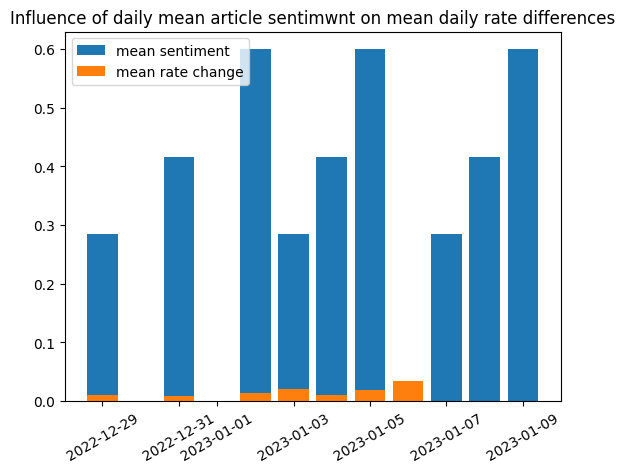

In [140]:
plt.bar(hb3['date'], hb3['sentiment'], label='mean sentiment')
plt.bar(out5['date'], out5['change'], label='mean rate change')

plt.xticks(rotation=30)
plt.legend()
plt.title('Influence of daily mean article sentimwnt on mean daily rate differences')
plt.show()

In [143]:
joined = out5.set_index('date').join(hb3.set_index('date'), how='inner')
joined

,change,sentiment
date,,
2023-01-05,0.018305,0.600000
2023-01-02,0.013366,0.600000
2022-12-29,0.011109,0.285714
2023-01-03,0.020219,0.285714
2023-01-04,0.011339,0.416667
2022-12-31,0.008432,0.416667


In [144]:
joined = joined.reset_index()
joined['date'] = joined['date'].astype(str)
joined = joined.set_index('date', drop=True)
joined

,change,sentiment
date,,
2023-01-05,0.018305,0.600000
2023-01-02,0.013366,0.600000
2022-12-29,0.011109,0.285714
2023-01-03,0.020219,0.285714
2023-01-04,0.011339,0.416667
2022-12-31,0.008432,0.416667


In [145]:
joined = joined.sort_index()

In [146]:
joined

,change,sentiment
date,,
2022-12-29,0.011109,0.285714
2022-12-31,0.008432,0.416667
2023-01-02,0.013366,0.600000
2023-01-03,0.020219,0.285714
2023-01-04,0.011339,0.416667
2023-01-05,0.018305,0.600000


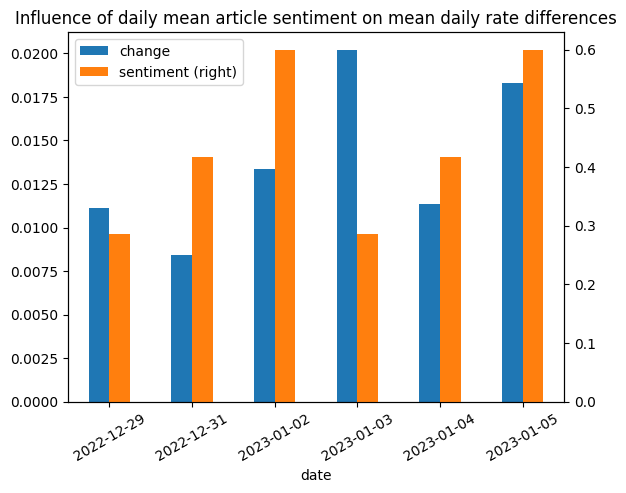

In [148]:
joined.plot(kind= 'bar', secondary_y='sentiment', rot=30)
plt.title('Influence of daily mean article sentiment on mean daily rate differences')
plt.show()

### Influence of news source on exchange rate

In [151]:
hb4 = filter_hbase(lambda x, y, z: True, [b'data:source_id', b'data:date'])
hb4.columns = ['source', 'date']
hb4.date = pd.to_datetime(hb4.date)
hb4.date = hb4['date'].dt.floor('d')
hb4['count'] = 1
hb4 = hb4.groupby(['source', 'date'])['count'].count()
hb4 = hb4.reset_index()

In [179]:
joined2 = out5.set_index('date').join(hb4.set_index('date'), how='inner')
joined2 = joined2.reset_index()

In [180]:
joined2 = joined2.groupby('source').agg({'count':'sum', 'change':'mean'})
joined2 = joined2.reset_index()
joined2.columns = ['News source', 'Articles', 'Mean rate change']
joined2

,News source,Articles,Mean rate change
0,benzinga,3,0.009885
1,bitcoin,12,0.013795
2,coindesk,3,0.015836
3,cryptoslate,3,0.009885
4,dailycoin,3,0.009885
5,gudstory,3,0.015836
6,insidebitcoins,3,0.009885
7,koreaittimes,3,0.015836
8,merca20,3,0.009885
9,mercury,6,0.009885


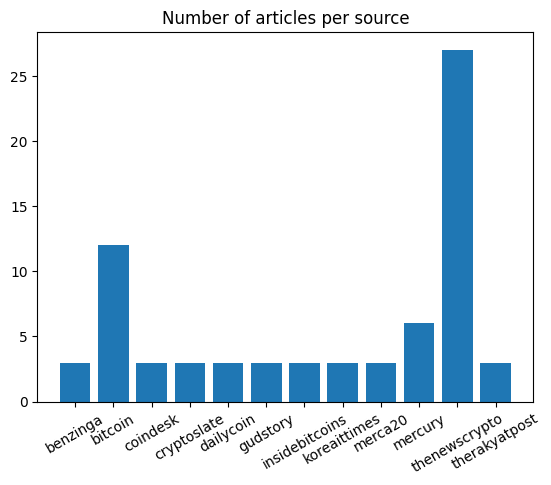

In [181]:
plt.bar(joined2['News source'], joined2['Articles'])
plt.xticks(rotation=30)
plt.title('Number of articles per source')
plt.show()

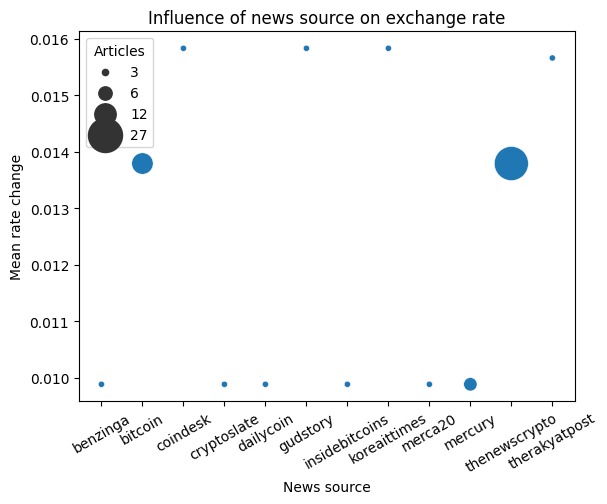

In [183]:
sns.scatterplot(data=joined2, x='News source', y='Mean rate change', size='Articles', sizes=(20, 600))
plt.xticks(rotation=30)
plt.title('Influence of news source on exchange rate')
plt.xlabel('News source')
plt.ylabel('Mean rate change')
plt.show()